In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import norm, beta, expon, gamma, t
from typing import Callable

import pyvinecopulib as pv
from pyvinecopulib import Bicop

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
import os
plt.style.use(['science', 'ggplot-ubs.mplstyle'])
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False

sns.set_context('talk')
palette = sns.color_palette(as_cmap=True)
fmt = 'pdf'

DATA = "../../001_Data"
OUT = "../Outputs/Figs"
TEX = "../../002_LaTeX/Figs/"
def savefig(name):
    plt.savefig(os.path.join(OUT, f'{name}.{fmt}'))
    plt.savefig(os.path.join(TEX, f'{name}.{fmt}'))
    
sns.color_palette()



[(0.30196078431372547, 0.23529411764705882, 0.1843137254901961),
 (0.7529411764705882, 0.44313725490196076, 0.33725490196078434),
 (0.9098039215686274, 0.7803921568627451, 0.403921568627451),
 (0.6431372549019608, 0.21568627450980393, 0.1450980392156863),
 (0.8117647058823529, 0.7411764705882353, 0.6078431372549019),
 (0.6823529411764706, 0.6901960784313725, 0.7019607843137254),
 (0.9294117647058824, 0.8431372549019608, 0.615686274509804),
 (0.4823529411764706, 0.49019607843137253, 0.5019607843137255),
 (0.9019607843137255, 0.7137254901960784, 0.6431372549019608),
 (0.27450980392156865, 0.2784313725490196, 0.28627450980392155),
 (0.6313725490196078, 0.8, 0.8941176470588236),
 (0.0, 0.5372549019607843, 0.5529411764705883),
 (0.7254901960784313, 0.6980392156862745, 0.6392156862745098),
 (0.22745098039215686, 0.3411764705882353, 0.5411764705882353),
 (0.7529411764705882, 0.8196078431372549, 0.6078431372549019),
 (0.4823529411764706, 0.4196078431372549, 0.34901960784313724),
 (0.6862745098039216, 0.7372549019607844, 0.8352941176470589),
 (0.4588235294117647, 0.592156862745098, 0.19215686274509805),
 (0.8784313725490196, 0.8352941176470589, 0.7411764705882353),
 (0.21176470588235294, 0.5725490196078431, 0.792156862745098),
 (0.6509803921568628, 0.7450980392156863, 0.396078431372549),
 (0.4235294117647059, 0.5294117647058824, 0.7019607843137254),
 (0.7529411764705882, 0.6, 0.4745098039215686),
 (0.592156862745098, 0.8274509803921568, 0.8),
 (0.43529411764705883, 0.7137254901960784, 0.8745098039215686),
 (0.8745098039215686, 0.6784313725490196, 0.13333333333333333),
 (0.3333333333333333, 0.6941176470588235, 0.7058823529411765)]

In [49]:
def plot_copula_density(copula, zmax = None, eps = 0.0, nx = 10,
                        alpha = .9, shade=False, levels = 10,
                        cmap = 'copper', antialiased =True, rot=(30, 290), **kwargs):
    fig = plt.figure()
    ax = plt.axes(projection='3d', fc='white')

    u = np.linspace(eps, 1-eps, nx)
    u, v = np.meshgrid(u, u)
    u_, v_ = u.flatten(), v.flatten()
    
    if isinstance(copula, Bicop):
        z_ = copula.pdf(np.vstack([u_, v_]).T)
        z = copula.pdf(np.vstack([u.ravel(), v.ravel()]).T).reshape(u.shape)
    elif isinstance(copula, Callable):
        z_ = copula(u_, v_)
        z = copula(u, v)
    else:
        raise NotImplementedError()
    zmax = np.max(z_) if zmax is None else zmax
    
    ax.plot_trisurf(u_, v_, z_, vmin=0.0, vmax=zmax, cmap=cmap, shade=shade, alpha = alpha, antialiased=antialiased, **kwargs)
    ax.contour(u, v, z, colors='black', levels=np.linspace(0, zmax, levels))

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, zmax)
    plt.tight_layout()
    ax.view_init(*rot)
    return fig, ax

def plot_copula_contour(copula, nx=30, levels=10, eps=0.0, cmap='copper', normalize=False, zmax=None, **kwargs):
    fig = plt.figure()
    ax = plt.axes()
    
    if not normalize:
        u = np.linspace(eps, 1-eps, nx)
        u, v = np.meshgrid(u, u)
        if isinstance(copula, Bicop):
            z = copula.pdf(np.vstack([u.ravel(), v.ravel()]).T).reshape(u.shape).T
        elif isinstance(copula, Callable):
            z = copula(u, v)
        else:
            raise NotImplementedError()
        zmax = np.max(z) if zmax is None else zmax
        cset = ax.contour(u, v, z, cmap=cmap, levels=np.linspace(0.0, zmax, levels), **kwargs)
        ax.clabel(cset, inline=True, colors='black', fontsize=12)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    else:
        x = np.linspace(-3+eps, 3-eps, 100)
        X, Y = np.meshgrid(x,x)
        NX = norm.cdf(X)
        NY = norm.cdf(Y)
        NGRID = np.stack((np.ravel(NX),np.ravel(NY)), axis = 1)

        nx = norm.pdf(x).reshape((1,len(x)))
        adj = (nx.transpose()*nx).ravel()
        
        if isinstance(copula, Bicop):
            z = copula.pdf(NGRID)
        elif isinstance(copula, Callable):
            z = copula(NX, NY)
        else:
            raise NotImplementedError()
        z = np.reshape(z*adj, X.shape)
        zmax = np.max(z) if zmax is None else zmax
        cset = ax.contour(X, Y, z, cmap=cmap, levels=np.linspace(0.0, zmax, levels), **kwargs)   
        ax.clabel(cset, inline=True, colors='black', fontsize=12)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)

    ax.set_aspect('equal', 'box')
    return fig, ax

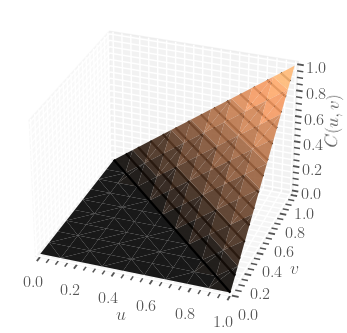

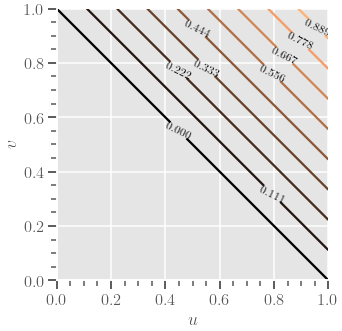

In [43]:
fig, ax = plot_copula_density(lambda u,v: np.maximum(u + v - 1, 0), levels=15)
ax.set_xlabel("$u$")
ax.set_ylabel("$v$")
ax.set_zlabel("$C(u,v)$")
savefig('02_MinimumCopula_surface');

fig, ax = plot_copula_contour(lambda u,v: np.maximum(u + v - 1, 0))
ax.set_xlabel("$u$")
ax.set_ylabel("$v$")
savefig('02_MinimumCopula_contour');

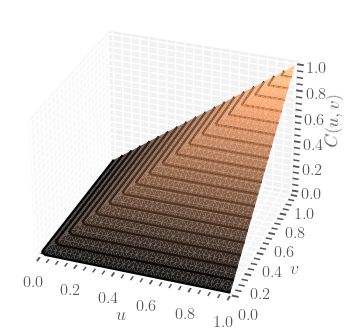

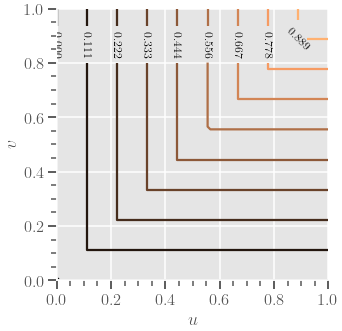

In [31]:
fig, ax = plot_copula_density(lambda u,v: np.minimum(u, v), levels=20, nx=40)
ax.set_xlabel("$u$")
ax.set_ylabel("$v$")
ax.set_zlabel("$C(u,v)$")
savefig('02_MaximumCopula_surface');

fig, ax = plot_copula_contour(lambda u,v: np.minimum(u,v), nx=100)
ax.set_xlabel("$u$")
ax.set_ylabel("$v$")
savefig('02_MaximumCopula_contour');

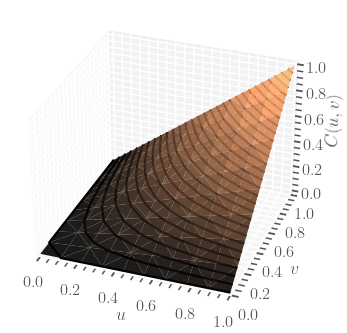

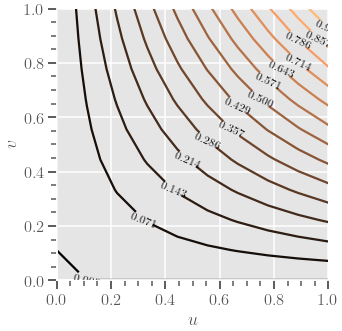

In [35]:
fig, ax = plot_copula_density(lambda u,v: u*v, levels=30)
ax.set_xlabel("$u$")
ax.set_ylabel("$v$")
ax.set_zlabel("$C(u,v)$")
savefig('02_ProductCopula_surface');

fig, ax = plot_copula_contour(lambda u,v: u*v, levels=15, nx=10)
ax.set_xlabel("$u$")
ax.set_ylabel("$v$")
savefig('02_ProductCopula_contour');

<ipython-input-45-8614bc660d73>:22: UserWarning: No contour levels were found within the data range.
  ax.contour(u, v, z, colors='black', levels=np.linspace(0, zmax, levels))
<ipython-input-45-8614bc660d73>:45: UserWarning: No contour levels were found within the data range.
  cset = ax.contour(u, v, z, cmap=cmap, levels=np.linspace(0.0, zmax, levels), **kwargs)


(10000,)
(100, 100)
(10000,)
(10000,)
(100, 100)
(10000,)
(10000,)
(100, 100)
(10000,)
(10000,)
(100, 100)
(10000,)
(10000,)
(100, 100)
(10000,)
(10000,)
(100, 100)
(10000,)


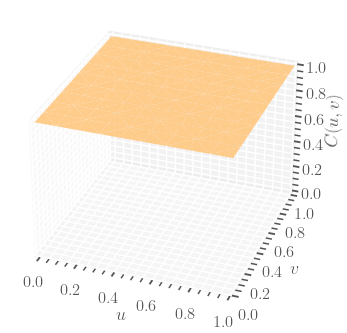

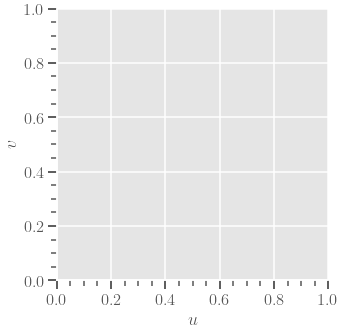

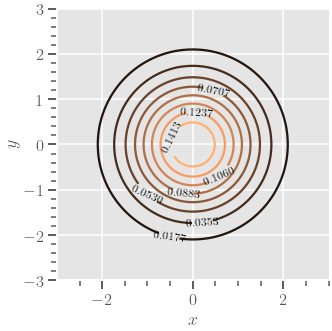

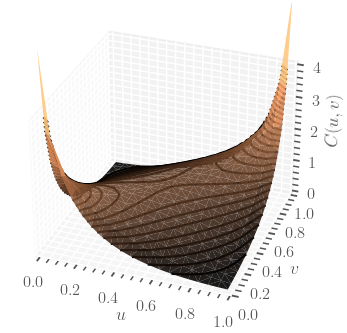

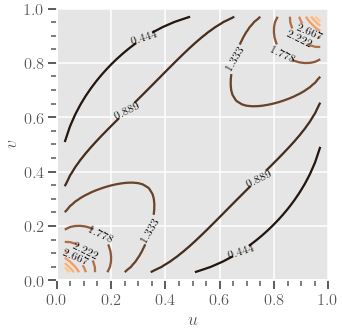

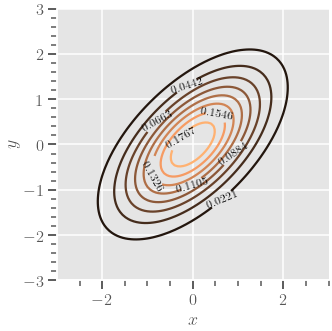

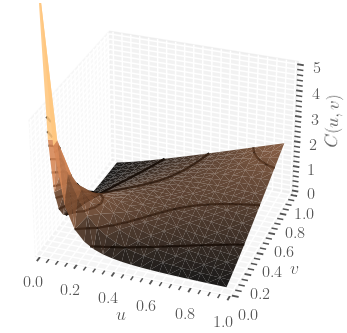

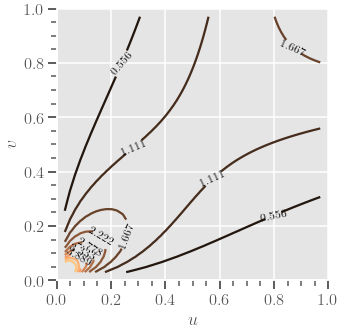

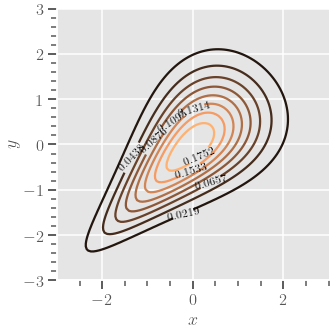

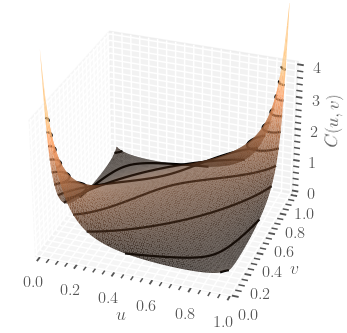

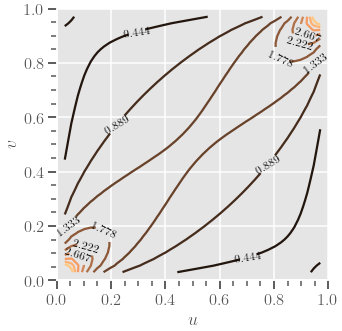

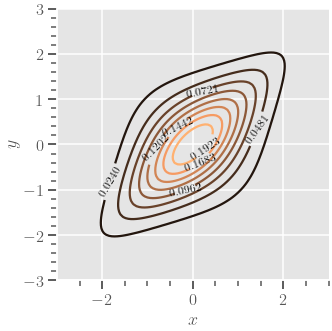

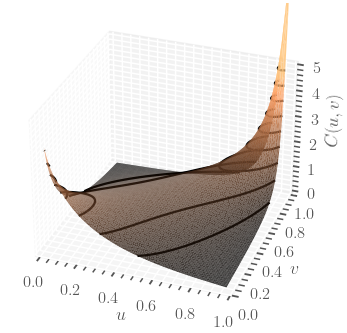

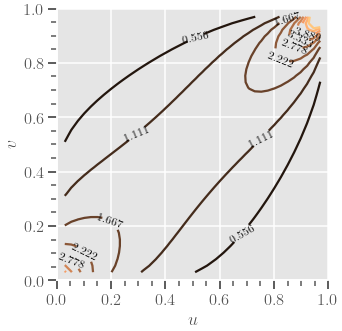

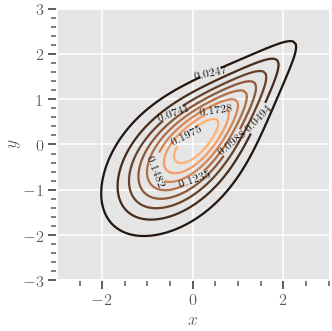

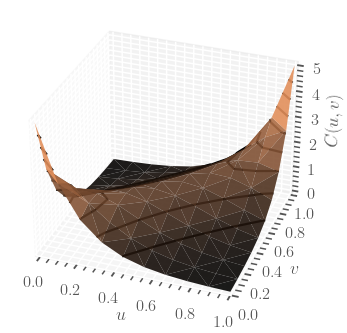

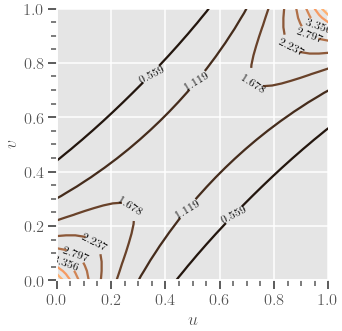

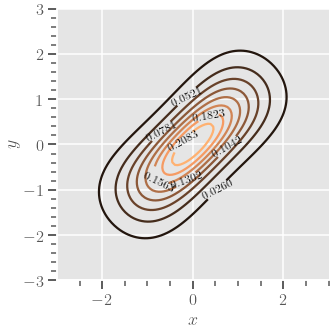

In [47]:
cops = {'Independence': {'copula': pv.Bicop(family = pv.indep, parameters=[]), 
                         'kw_surface': {},
                         'kw_contour': {}, 
                         'kw_contour_n': {}},
        'Gaussian': {"copula": pv.Bicop(family = pv.gaussian, parameters = [0.6]),
                     "kw_surface": {"eps":0.02, "nx":20, "zmax":4, "levels":30},
                     "kw_contour": {"levels": 10, "eps":0.03, "nx":50, "zmax": 4},
                     "kw_contour_n": {}},
        'Clayton': {"copula": pv.Bicop(family=pv.clayton, parameters=[1.2]),
                    "kw_surface": {"eps":0.03, "nx":20, "levels":10, "zmax":5},
                    "kw_contour": {"levels":10, "eps":0.03, "nx":50, "zmax":5},
                    "kw_contour_n": {"levels":10, "eps":0.03, "nx":50}},
        'Student': {"copula": pv.Bicop(family=pv.student, parameters=[0.5, 3]),
                    "kw_surface": {"eps":0.03, "zmax":4, "nx":100},
                    "kw_contour": {"eps":0.03, "zmax":4, "nx":40, "levels":10},
                    "kw_contour_n": {"levels":10}},
        'Gumbel': {"copula": pv.Bicop(family=pv.gumbel, parameters=[1.8]),
                   "kw_surface": {"eps":0.03, "zmax":5, "nx":100},
                   "kw_contour": {"eps":0.03, "zmax":5, "nx":40, "levels":10},
                   "kw_contour_n": {"levels":10}},
        'Frank': {"copula": pv.Bicop(family=pv.frank, parameters=[5]),
                  "kw_surface": {},
                  "kw_contour": {},
                  "kw_contour_n": {}}}

for name, params in cops.items():
    cop = params['copula']
    fig, ax = plot_copula_density(cop, **params['kw_surface'])
    ax.set_xlabel("$u$")
    ax.set_ylabel("$v$")
    ax.set_zlabel("$C(u,v)$")
    savefig(f'02_{name}Copula_density');
    
    fig, ax = plot_copula_contour(cop, **params['kw_contour'])
    ax.set_xlabel("$u$")
    ax.set_ylabel("$v$")
    savefig(f'02_{name}Copula_contour');
        
    fig, ax = plot_copula_contour(cop, normalize=True, **params['kw_contour_n'])
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    savefig(f'02_{name}Copula_contour_norm');

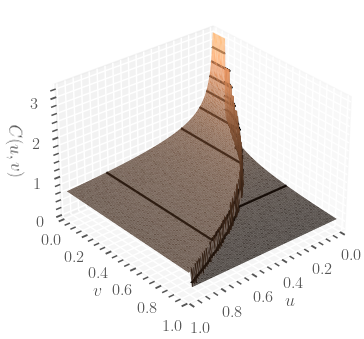

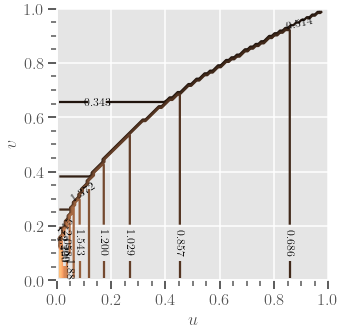

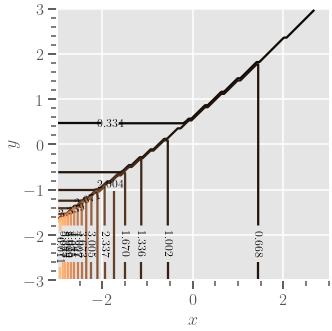

In [64]:
def marshall_olkin_density(u, v, m = 0.35, n=0.75):
    result = np.zeros_like(u)
    result[u**m > v**n] = (1-m)*u[u**m > v**n]**(-m)
    result[u**m < v**n] = (1-n)*v[u**m < v**n]**(-n)
    return result

cop = marshall_olkin_density
name="MarshallOlkin"
fig, ax = plot_copula_density(cop, eps = 0.01, nx=100, rot =(30, 50))
ax.set_xlabel("$u$")
ax.set_ylabel("$v$")
ax.set_zlabel("$C(u,v)$")
savefig(f'02_{name}Copula_density');
    
fig, ax = plot_copula_contour(cop, eps = 0.01, levels=20, nx=100)
ax.set_xlabel("$u$")
ax.set_ylabel("$v$")
savefig(f'02_{name}Copula_contour');
    
x = np.linspace(-3+eps, 3-eps, 100)
X, Y = np.meshgrid(x,x)
NX = norm.cdf(X)
NY = norm.cdf(Y)
zmax=None
cmap='copper'
levels = 20
fig, ax =plt.subplots()
z = np.reshape(marshall_olkin_density(NX, NY), X.shape)
zmax = np.max(z) if zmax is None else zmax
cset = ax.contour(X, Y, z, cmap=cmap, levels=np.linspace(0.0, zmax, levels))   
ax.clabel(cset, inline=True, colors='black', fontsize=12)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_aspect('equal', 'box')
savefig(f'02_{name}Copula_contour_norm');